In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
import torch
print("¿CUDA disponible?", torch.cuda.is_available())
print("GPU utilizada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

¿CUDA disponible? True
GPU utilizada: Tesla T4


In [ ]:
df = pd.read_parquet("df_step2.parquet")

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 497975 entries, 0 to 551442
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   Lyrics                          497975 non-null  object
 1   Length                          497975 non-null  object
 2   emotion                         497975 non-null  object
 3   Genre                           497975 non-null  object
 4   Key                             497975 non-null  object
 5   Tempo                           497975 non-null  object
 6   Loudness                        497975 non-null  object
 7   Time signature                  497975 non-null  object
 8   Explicit                        497975 non-null  object
 9   Popularity                      497975 non-null  object
 10  Energy                          497975 non-null  object
 11  Danceability                    497975 non-null  object
 12  Positiveness                    497

### Embeddings

In [ ]:
# use a sample of the dataset, or the full dataset
useASample = False
if (useASample):
    df = df.sample(n=1000, random_state=42)

In [7]:
# Instanciás el modelo preentrenado
model = SentenceTransformer('all-MiniLM-L6-v2')

# Transformar todas las columnas a embeddings, excepto la variable objetivo 'emotion'
embeddings = model.encode(df.drop(columns=['emotion']).astype(str).to_numpy().tolist(), convert_to_tensor=False, show_progress_bar=True)

# Convertís los embeddings a DataFrame
embeddings_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])

# Reseteás el índice de ambos DataFrames
df = df.reset_index(drop=True)
embeddings_df = embeddings_df.reset_index(drop=True)

# Concatenás solo los embeddings y la variable objetivo 'emotion'
df_final = pd.concat([embeddings_df, df['emotion'].reset_index(drop=True)], axis=1)

# Mostrás el resultado
df_final.head()

Batches:   0%|          | 0/15562 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,emotion
0,0.011005,-0.044997,0.088210,0.049423,0.042466,0.020175,0.094143,0.024076,0.062899,-0.032953,...,-0.032029,0.011278,-0.022775,-0.084471,-0.036755,-0.023963,0.038205,-0.086942,0.010753,sadness
1,-0.056493,-0.078639,0.032256,-0.004062,0.115658,0.007530,0.154361,0.029722,0.075450,-0.026232,...,0.093776,-0.047271,0.098650,0.011928,-0.031115,0.024640,0.047489,-0.016773,-0.088005,sadness
2,0.021731,-0.022307,0.017177,-0.076795,0.059049,-0.023759,0.025111,0.023382,0.046143,0.008102,...,-0.050086,-0.038419,0.092179,-0.060033,0.038237,0.001501,0.045952,-0.015487,-0.090251,joy
3,-0.072931,-0.024942,0.082103,0.041710,0.077947,0.022448,0.081504,-0.014423,0.037461,-0.080806,...,0.012451,0.002006,0.037113,0.008294,-0.045536,0.031986,0.045027,-0.118700,-0.102250,joy
4,-0.090663,0.065250,-0.030084,-0.028109,0.063334,0.087580,0.175540,-0.041793,0.044873,-0.033336,...,-0.004444,0.086782,0.080833,-0.032284,0.018646,-0.019375,0.039816,-0.046415,-0.084832,joy


In [8]:
# Guardar el DataFrame modificado en formato eficiente
embeddings_df.to_parquet("df_step3.it2.embeddingsDf.parquet")
df_final.to_parquet("df_step3.it2.dfFinal.parquet")

### PCA sobre embeddings

In [9]:
pca = PCA(random_state=42)
embeddings_pca = pca.fit_transform(embeddings_df)

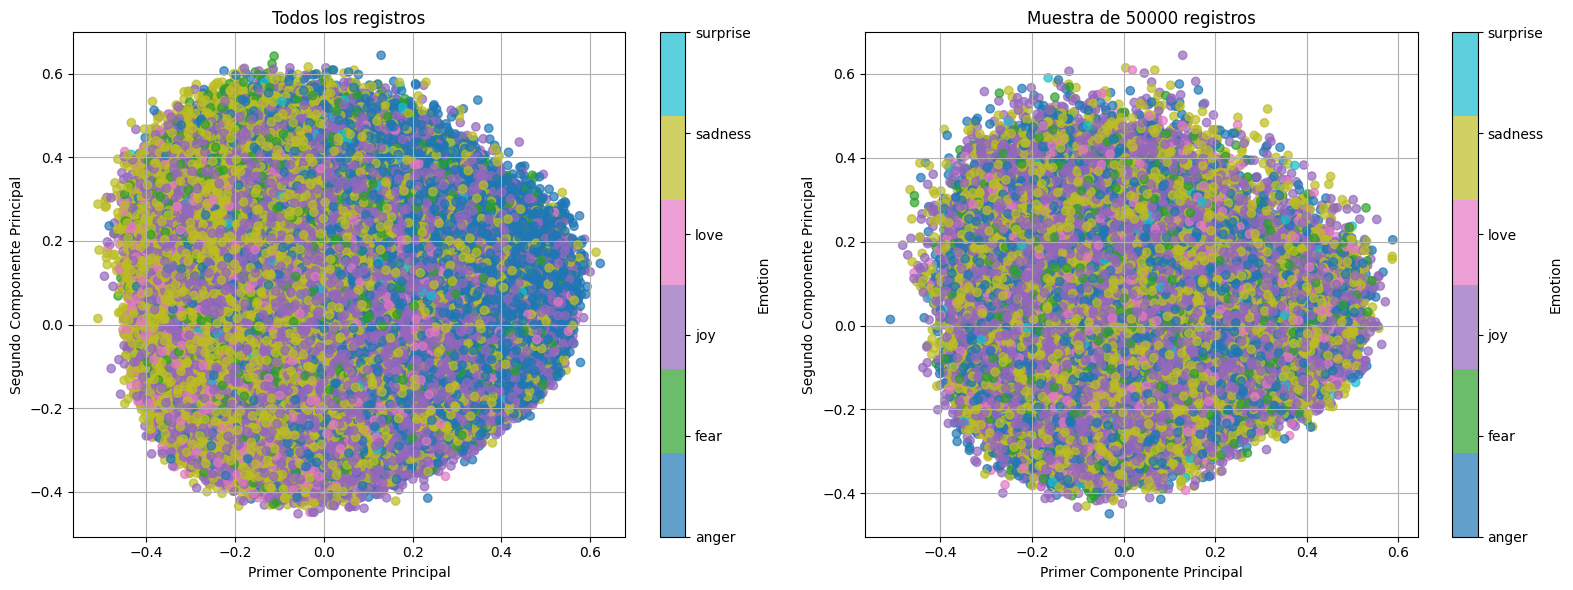

In [14]:
# Función para graficar dispersión de PCA
def plot_pca_scatter(embeddings, df_plot, title):
    emotions = df_plot['emotion'].astype('category')
    codes = emotions.cat.codes
    labels = emotions.cat.categories
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=codes, cmap=plt.get_cmap('tab10', len(labels)), alpha=0.7)
    plt.xlabel('Primer Componente Principal')
    plt.ylabel('Segundo Componente Principal')
    plt.title(title)
    cb = plt.colorbar(scatter, ticks=range(len(labels)))
    cb.ax.set_yticklabels(labels)
    cb.set_label('Emotion')
    plt.grid(True)

# Preparar datos para ambos gráficos
sample_size = 50000
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    embeddings_pca_sample = embeddings_pca[df_sample.index]
else:
    df_sample = df.reset_index(drop=True)
    embeddings_pca_sample = embeddings_pca

# Mostrar ambos gráficos uno al lado del otro
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_pca_scatter(embeddings_pca, df.reset_index(drop=True), 'Todos los registros')
plt.subplot(1, 2, 2)
plot_pca_scatter(embeddings_pca_sample, df_sample, f'Muestra de {len(df_sample)} registros')
plt.tight_layout()
plt.show()

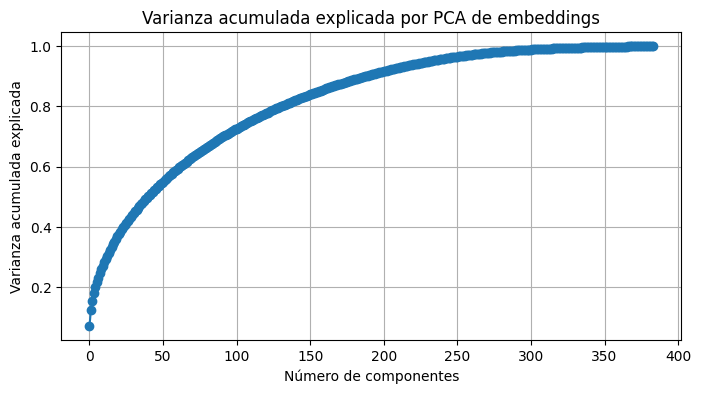

In [11]:
# Plot de la varianza acumulada
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada explicada por PCA de embeddings')
plt.grid(True)
plt.show()

In [ ]:
# Tabla de número de componentes necesarios para explicar distintos porcentajes de varianza
porcentajes = [0.75, 0.80, 0.85, 0.90, 0.95]
componentes = [np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p) + 1 for p in porcentajes]
tabla = pd.DataFrame({
    'Porcentaje de varianza': [f'{int(p*100)}%' for p in porcentajes],
    'N° de componentes': componentes
})
tabla

,Porcentaje de varianza,N° de componentes
0,75%,110
1,80%,132
2,85%,157
3,90%,189
4,95%,232


In [ ]:
pca = PCA(n_components=0.80, random_state=42)
embeddings_pca_final = pca.fit_transform(embeddings_df)

### Normalizar los embeddings PCA

In [ ]:
# Normalizamos los embeddings PCA
scaler = MinMaxScaler()

embeddings_pca_final = scaler.fit_transform(embeddings_pca_final)

# Convertimos a DataFrame
embeddings_pca_final_df = pd.DataFrame(embeddings_pca_final,
                                                    columns=[f'emb_pca_{i}' for i in range(embeddings_pca_final.shape[1])])

# Concatenamos al dataset original
df_final_pca = pd.concat([embeddings_pca_final_df, df['emotion'].reset_index(drop=True)], axis=1)


In [ ]:
# Guardar el DataFrame modificado en formato eficiente
df_final_pca.to_parquet("df_step3.it2.full.parquet")

# RF

In [ ]:
# DO NOT RUN IN COLAB
# df = pd.read_parquet("df_step3.it2.full.parquet")
# df.info(verbose=True)

# X = df.drop(columns=["emotion"])
# y = df["emotion"]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, stratify=y, random_state=42
# )

# param_grid = {
#     'n_estimators': [100, 200],           # cantidad de árboles
#     'max_depth': [10, 20, None],          # profundidad máxima
#     'min_samples_split': [2, 5],          # mínimo de muestras para dividir un nodo
#     'min_samples_leaf': [1, 2],           # mínimo de muestras en una hoja
#     'max_features': ['sqrt', 'log2'],     # cantidad de features a usar en cada split
#     'bootstrap': [True, False]            # usar bootstrap samples o no
# }

# rf = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train, y_train)

In [ ]:
# DO NOT RUN IN COLAB
# print("Mejores parámetros:")
# print(grid_search.best_params_)

# print("Accuracy en test:")
# print(grid_search.score(X_test, y_test))

In [ ]:
# DO NOT RUN IN COLAB
# rf = RandomForestClassifier(
#     n_estimators=grid_search.best_params_['n_estimators'],
#     max_depth=grid_search.best_params_['max_depth'],
#     min_samples_split=grid_search.best_params_['min_samples_split'],
#     min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
#     max_features=grid_search.best_params_['max_features'],
#     bootstrap=grid_search.best_params_['bootstrap'],
#     random_state=42
# )
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nReporte de clasificación:")
# print(classification_report(y_test, y_pred))

# KNN

In [ ]:
# DO NOT RUN IN COLAB
# df = pd.read_parquet("df_step3.it2.full.parquet")
# df.info(verbose=True)

# # Entrenamiento
# X = df.drop(columns=["emotion"])
# y = df["emotion"]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan'],
#     'leaf_size': [20, 30, 40],
# }

# knn = KNeighborsClassifier()

# grid_search = GridSearchCV(
#     estimator=knn,
#     param_grid=param_grid,
#     cv=3,
#     scoring='accuracy',  # se puede omitir, pero es buena práctica especificarlo
#     n_jobs=-1,
#     verbose=1
# )
# grid_search.fit(X_train, y_train)

# y_pred = knn.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nReporte de clasificación:")
# print(classification_report(y_test, y_pred))

In [ ]:
# DO NOT RUN IN COLAB
# print("Mejores parámetros encontrados:")
# print(grid_search.best_params_)

# print("Accuracy en test:")
# print(grid_search.score(X_test, y_test))

In [ ]:
# DO NOT RUN IN COLAB
# knn = KNeighborsClassifier(
#     n_neighbors=grid_search.best_params_['n_neighbors'],
#     weights=grid_search.best_params_['weights'],
#     metric=grid_search.best_params_['metric'],
#     leaf_size=grid_search.best_params_['leaf_size']
# )

# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nReporte de clasificación:")
# print(classification_report(y_test, y_pred))